In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

%matplotlib inline

In [118]:
# !pip install gensim==3.0.0

In [119]:
# !pip install scipy==1.0.0

In [120]:
df = pd.read_csv("test.csv")
df.head()
df.columns

Index(['Unnamed: 0', 'cid', 'smiles', 'action'], dtype='object')

In [121]:
import gensim
gensim.__version__

'3.0.0'

In [122]:
# remove null values
df = df[~df["action"].isnull()]

In [123]:
df['action'].value_counts()

AGONIST            108
ANTAGONIST          57
FULL AGONIST        19
PARTIAL AGONIST     14
POSITIVE             4
BINDER               2
NEUTRAL              2
BIASED AGONIST       2
OTHER/UNKNOWN        1
LIGAND               1
Name: action, dtype: int64

In [124]:
def parse(x):
    x = str(x)
    if x.startswith("FULL "):
        return "AGONIST"
    else:
        return x
        
df["action_gen"] = df["action"].apply(parse)
df["action_gen"].value_counts()

AGONIST            127
ANTAGONIST          57
PARTIAL AGONIST     14
POSITIVE             4
BINDER               2
NEUTRAL              2
BIASED AGONIST       2
OTHER/UNKNOWN        1
LIGAND               1
Name: action_gen, dtype: int64

In [125]:
condition = (df.action_gen != "AGONIST") & (df.action_gen != "ANTAGONIST") & (df.action_gen != "PARTIAL AGONIST")
df["action_gen"] = np.where(condition, "OTHER", df.action_gen)
df["action_gen"].value_counts()

AGONIST            127
ANTAGONIST          57
PARTIAL AGONIST     14
OTHER               12
Name: action_gen, dtype: int64

In [126]:
df = df.drop_duplicates(subset=['cid'])
df = df[['cid', 'smiles', 'action', 'action_gen']]
df.set_index('cid', inplace=True)
df.to_csv('basic_data.csv')

In [127]:
df.shape

(171, 3)

In [128]:
print(">>> create mol from smiles ... ")
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 

print(">>> create sentence from mol ... ")
df['sentence'] = df.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], radius=1)), axis=1)

print(">>> load the word2vec model ... ")
from gensim.models import word2vec
w2v_model = word2vec.Word2Vec.load('model\\model_300dim.pkl')
# w2v_model = word2vec.Word2Vec.load('model_300dim.pkl')

print(">>> create embedding from sentence ... ")
df['embedding'] = [DfVec(x) for x in sentences2vec(df['sentence'], w2v_model)]

print(">>> data columns = ", df.columns, "\n")

df_mol2vec = np.array([x.vec for x in df['embedding']])
df_mol2vec = pd.DataFrame(df_mol2vec)


>>> create mol from smiles ... 
>>> create sentence from mol ... 
>>> load the word2vec model ... 
>>> create embedding from sentence ... 
>>> data columns =  Index(['smiles', 'action', 'action_gen', 'mol', 'sentence', 'embedding'], dtype='object') 



In [129]:
df_mol2vec

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,6.280141,-0.328470,2.414576,-1.690867,-7.861639,-6.867691,-9.626471,-13.199176,-1.294791,-11.148396,...,19.299658,2.169511,-0.793115,-16.764660,13.043880,-18.739483,3.756747,15.374719,-14.515256,-6.286633
1,1.776356,3.756445,-6.181037,-5.822800,-5.826627,-4.405025,-8.603537,-10.111814,-4.385093,-8.642610,...,16.824162,5.012199,-1.432787,-14.343889,10.836793,-18.628334,1.475181,15.598952,-10.674813,-5.693790
2,6.314234,5.259421,-0.680459,-7.090142,-2.442776,-9.001303,-11.153745,-11.118653,-4.218091,-11.227092,...,20.611570,7.556344,-1.368805,-18.631535,10.332385,-18.168184,-0.347461,11.707021,-13.346869,-9.483927
3,3.372167,-0.755933,-3.060266,-4.772605,-6.081095,-6.983521,-10.408932,-9.785253,-7.122725,-12.498787,...,19.356724,8.006906,-1.125456,-17.910374,7.266664,-21.190121,2.686775,13.276052,-11.772227,-3.436572
4,-1.496679,6.152759,0.588301,-6.650611,-5.761706,-5.832739,-4.404896,-4.544698,-2.249762,-4.385048,...,13.872375,1.219543,-6.606980,-8.758172,7.176021,-14.006166,5.154285,11.168540,-6.243005,-2.394396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,3.702456,-1.441905,-3.830351,-4.911148,-9.687961,-5.936050,-11.954692,-8.482609,-2.526412,-11.928185,...,18.830000,3.986431,-5.243053,-14.841425,6.901628,-23.908350,2.742482,15.500882,-11.651638,-2.351627
167,3.461288,-1.513749,-3.431657,-5.302059,-9.319710,-5.905469,-11.412456,-8.100624,-2.178119,-11.863521,...,18.322538,4.380358,-5.922580,-15.014755,6.630800,-23.506742,2.896177,15.085280,-11.980536,-2.415028
168,-0.374055,3.579891,-6.851539,-12.594655,-7.360147,-5.953069,-13.223902,-11.967194,1.312468,-4.554150,...,26.341173,-1.922469,-4.906705,-22.792141,18.464617,-28.491587,12.383924,20.470411,-24.913034,-1.457546
169,3.816453,0.769446,-2.545771,-5.988578,-10.221293,-4.583409,-9.938968,-15.230546,-2.148406,-19.600471,...,23.059633,7.594724,-7.413008,-14.945212,17.409239,-31.190739,4.204212,17.317575,-16.193220,-1.041622


In [130]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder


In [131]:
# add indexes to dictionary
df.reset_index(inplace=True)
# encoding
# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()
# df['encoded_label'] = labelencoder.fit_transform(df['action_gen'])
df

,cid,smiles,action,action_gen,mol,sentence,embedding
0,2159,CCN1CCCC1CNC(=O)C2=CC(=C(C=C2OC)N)S(=O)(=O)CC,AGONIST,AGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 225184566...","(100,) dimensional vector"
1,2160,CN(C)CCC=C1C2=CC=CC=C2CCC3=CC=CC=C31,BINDER,OTHER,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3818546315, 848128881, 3121777292...","(100,) dimensional vector"
2,2562,CCN(CC)CCOCCOC(=O)C1(CCCC1)C2=CC=CC=C2,ANTAGONIST,ANTAGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 592593828...","(100,) dimensional vector"
3,3345,CCC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3,AGONIST,AGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 206478835...","(100,) dimensional vector"
4,3821,CNC1(CCCCC1=O)C2=CC=CC=C2Cl,BINDER,OTHER,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3824063894, 847961216, 1733418522...","(100,) dimensional vector"
...,...,...,...,...,...,...,...
166,132990963,C1CCC(CC1)N2CCN(CC2)C(CC3=CC=CC=C3)C4=CC=C(C=C4)F,AGONIST,AGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2968968094, 2142032900, 2968968094, 214203290...","(100,) dimensional vector"
167,132990975,C1CCC(CC1)N2CCN(CC2)C(CC3=CC=CC=C3)C4=CC=CC=C4F,AGONIST,AGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2968968094, 2142032900, 2968968094, 214203290...","(100,) dimensional vector"
168,134156377,CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)OC)O[C...,AGONIST,AGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3657471097, 2092489639, 201425559...","(100,) dimensional vector"
169,137434175,CCC1=CC2=C(C(=C(N=C2C(=C1)F)N3CCC(CC3)NC4CCOCC...,ANTAGONIST,ANTAGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 618671879...","(100,) dimensional vector"


In [132]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import rand_score

In [133]:
# scaler = StandardScaler()
# df_mol2vec = scaler.fit_transform(df_mol2vec)

# scaler = MinMaxScaler()
# df_mol2vec = scaler.fit_transform(df_mol2vec)


0.9999999403461572


c:\Users\Public\anaconda3\envs\m2vec\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


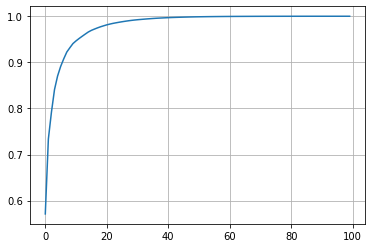

In [134]:
scaler = StandardScaler()
df_mol2vec_scaled = scaler.fit_transform(df_mol2vec)

pca = PCA().fit(df_mol2vec_scaled)
pc = pca.transform(df_mol2vec_scaled)

var = pca.explained_variance_ratio_[:10]
cum_sum = np.cumsum(pca.explained_variance_ratio_)
labels = ['PC'+ str(i) for i in range(1,11)]

print(sum(pca.explained_variance_ratio_))
# sns.barplot(labels, var)
sns.lineplot([x for x in range(len(cum_sum))], cum_sum)
plt.grid()
plt.show()

## TSNE 2 dim

c:\Users\Public\anaconda3\envs\m2vec\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\Public\anaconda3\envs\m2vec\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


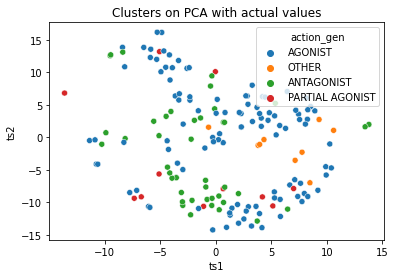

In [135]:
np.random.seed(42)

scaler = StandardScaler()
df_mol2vec_scaled = scaler.fit_transform(df_mol2vec)
pca_num_components = 5

# reduced_data = PCA(n_components=pca_num_components).fit_transform(df_mol2vec_scaled)
# results = pd.DataFrame(reduced_data,columns=['pc' + str(x) for x in range(1, pca_num_components + 1)])

tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_mol2vec)

tsne_results = pd.DataFrame(tsne_results, columns=['ts1', 'ts2'])
sns.scatterplot(x='ts1', y="ts2", hue=df['action_gen'], data=tsne_results)
plt.title('Clusters on PCA with actual values')
plt.show()

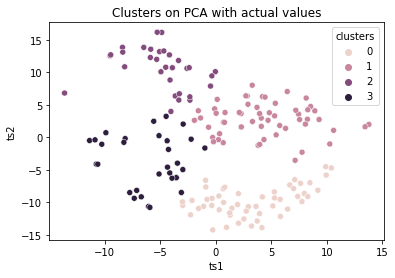

In [136]:
clustering_kmeans = KMeans(n_clusters=4)
tsne_results['clusters'] = clustering_kmeans.fit_predict(tsne_results)
tsne_results['clusters']

sns.scatterplot(x='ts1', y="ts2", hue=tsne_results['clusters'], data=tsne_results)
plt.title('Clusters on PCA with actual values')
plt.show()

In [137]:
print(tsne_results['clusters'].value_counts())
cluster_dict = dict(tsne_results['clusters'].value_counts())
cluster_dict = dict(sorted(cluster_dict.items(), key=lambda item: item[1], reverse=True)).keys()
cluster_dict = list(cluster_dict)

tsne_results['action_gen'] = df['action_gen']
tsne_results['action_gen_cluster'] = tsne_results['clusters'].map({cluster_dict[0]: 'AGONIST', cluster_dict[1]: 'ANTAGONIST', cluster_dict[2]: 'ANTAGONIST', cluster_dict[3]: 'OTHER'})

print('pairing_score: ', rand_score(tsne_results.action_gen, tsne_results.action_gen_cluster))
tsne_results[tsne_results.action_gen == tsne_results.action_gen_cluster].shape[0] / tsne_results.shape[0]
print('Accuracy', tsne_results[tsne_results.action_gen == tsne_results.action_gen_cluster].shape[0] / tsne_results.shape[0])

1    57
0    52
2    31
3    31
Name: clusters, dtype: int64
pairing_score:  0.5223942208462332
Accuracy 0.3684210526315789


## LDA

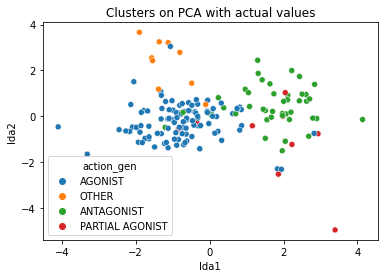

In [138]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split

np.random.seed(42)
df_mol2vec_scaled = df_mol2vec
scaler = StandardScaler()
df_mol2vec_scaled = pd.DataFrame(scaler.fit_transform(df_mol2vec))
df_mol2vec_scaled['action_gen'] = df['action_gen']


# normal LDA 
n_comp = 2
# lda = LDA(n_components=n_comp).fit(df_mol2vec_scaled.iloc[:, :-1], df_mol2vec_scaled.iloc[:, -1])

# normal LDA with partial training set to prevent overfitting
# df_sample = df_mol2vec_scaled.sample(n=140)
# lda = LDA(n_components=n_comp).fit(df_sample.iloc[:, :-1], df_sample.iloc[:, -1])

# solve generalized eigenvalue problem
X_train, X_test, y_train, y_test = train_test_split(df_mol2vec_scaled.iloc[:, :-1], df_mol2vec_scaled.iloc[:, -1], 
                                                train_size=0.6, random_state=42)
lda = LDA(n_components=n_comp, solver='eigen', shrinkage=0.2).fit(X_train, y_train)

df_mol2vec_scaled.drop("action_gen", axis=1, inplace=True)
lda_results = lda.transform(df_mol2vec_scaled)

lda_results = pd.DataFrame(lda_results, columns=['lda' + str(i) for i in range(1, n_comp+1)])
sns.scatterplot(x='lda1', y="lda2", hue=df['action_gen'], data=lda_results)
plt.title('Clusters on PCA with actual values')
plt.show()

In [139]:
# # loop for Fisher’s LDA
# rand_score_list = []
# shrink_list = np.round_(np.cumsum([0.1 for x in range(10)]), decimals=2)
# train_size_list = np.round(np.cumsum([0.1 for x in range(10)]), decimals=2)

# for shrink in shrink_list:
#     shrink_temp_list = []
#     for train_size in train_size_list:
#         # scaler = StandardScaler()
#         # df_mol2vec_scaled = pd.DataFrame(scaler.fit_transform(df_mol2vec))
#         try:
#             df_mol2vec_scaled['action_gen'] = df['action_gen']

#             X_train, X_test, y_train, y_test = train_test_split(df_mol2vec_scaled.iloc[:, :-1], df_mol2vec_scaled.iloc[:, -1], train_size=train_size, random_state=42)
#             n_comp = 2
#             lda = LDA(n_components=n_comp, solver='eigen', shrinkage=shrink).fit(X_train, y_train)
            
#             df_mol2vec_scaled.drop("action_gen", axis=1, inplace=True)
#             lda_results = lda.transform(df_mol2vec_scaled)

#             lda_results = pd.DataFrame(lda_results, columns=['ld' + str(i) for i in range(1, n_comp+1)])

#             clustering_kmeans = KMeans(n_clusters=4)
#             lda_results['clusters'] = clustering_kmeans.fit_predict(lda_results)
#             rd_sc = rand_score(df.action_gen, lda_results.clusters)
#             shrink_temp_list.append(rd_sc)
#         except:
#             shrink_temp_list.append(0)


#     rand_score_list.append(shrink_temp_list)

# # sns.lineplot(x_val, rand_score_list)
# # plt.grid()
# # plt.show()

# rand_score_df = pd.DataFrame(rand_score_list, columns=train_size_list, index=shrink_list)
# f, ax = plt.subplots(figsize=(20, 15))
# s = sns.heatmap(rand_score_df, annot=True)
# s.set(xlabel='train_size_list', ylabel='shrink_list')


In [140]:
# sample_size_list = [x for x in range(10, 170, 10)]
# rand_score_list = []

# np.random.seed(42)
# for sample_size in sample_size_list:
#     df_mol2vec_scaled['action_gen'] = df['action_gen']

#     df_sample = df_mol2vec_scaled.sample(n=sample_size)
#     lda = LDA(n_components=2).fit(df_sample.iloc[:, :-1], df_sample.iloc[:, -1])

#     df_mol2vec_scaled.drop("action_gen", axis=1, inplace=True)
#     lda_results = lda.transform(df_mol2vec_scaled)



#     lda_results = pd.DataFrame(lda_results, columns=['lda1', 'lda2'])

#     clustering_kmeans = KMeans(n_clusters=4)
#     lda_results['clusters'] = clustering_kmeans.fit_predict(lda_results)
#     rd_sc = rand_score(df.action_gen, lda_results.clusters)
#     rand_score_list.append(rd_sc)

# sns.lineplot(sample_size_list, rand_score_list)
# plt.grid()
# plt.show()
    

In [141]:
lda.transform(df_mol2vec.iloc[50:51, :])

array([[12.68061331, -0.1667465 ]])

In [142]:
clustering_kmeans = KMeans(n_clusters=4)
lda_results['clusters'] = clustering_kmeans.fit_predict(lda_results)
lda_results['clusters'].value_counts()

0    100
2     46
1     14
3     11
Name: clusters, dtype: int64

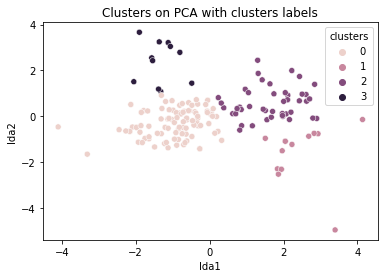

In [143]:
sns.scatterplot(x="lda1", y="lda2", hue=lda_results['clusters'], data=lda_results)
plt.title('Clusters on PCA with clusters labels')
plt.show()

In [144]:


print(lda_results['clusters'].value_counts())
# sort keys based on number of values in each clusters
cluster_dict = dict(lda_results['clusters'].value_counts())
cluster_dict = dict(sorted(cluster_dict.items(), key=lambda item: item[1], reverse=True)).keys()
cluster_dict = list(cluster_dict)

lda_results['action_gen'] = df['action_gen']
lda_results['action_gen_cluster'] = lda_results['clusters'].map({cluster_dict[0]: 'AGONIST', cluster_dict[1]: 'ANTAGONIST', cluster_dict[2]: 'PARTIAL AGONIST', cluster_dict[3]: 'OTHER'})

print('pairing_score: ', rand_score(lda_results.action_gen, lda_results.action_gen_cluster))
lda_results[lda_results.action_gen == lda_results.action_gen_cluster].shape[0] / lda_results.shape[0]
# print('Accuracy', accuracy_score(lda_results.action_gen, lda_results.action_gen_cluster))
print(classification_report(lda_results.action_gen, lda_results.action_gen_cluster))


0    100
2     46
1     14
3     11
Name: clusters, dtype: int64
pairing_score:  0.808531131750946
                 precision    recall  f1-score   support

        AGONIST       0.94      0.87      0.90       108
     ANTAGONIST       0.76      0.81      0.79        43
          OTHER       0.73      0.89      0.80         9
PARTIAL AGONIST       0.43      0.55      0.48        11

       accuracy                           0.84       171
      macro avg       0.71      0.78      0.74       171
   weighted avg       0.85      0.84      0.84       171



In [145]:
df.action_gen.value_counts()/df.shape[0]

AGONIST            0.631579
ANTAGONIST         0.251462
PARTIAL AGONIST    0.064327
OTHER              0.052632
Name: action_gen, dtype: float64